# Introduction

- Data contains a column with aircraft-reported climb rate. This is instantaneous, but incorrect in few cases (assuming the altitude to be accurate)
- Overall idea: smooth out the altitude vs time graph and identify points where decisions regarding altitude are made
    - Example: climb, maintain altitude / cruise, descend
- Post processing is done after smoothing using splines to eliminate false positives caused due to jitter in altitude

In [1]:
library(dplyr)
library(data.table)
library(parallel)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'data.table'

The following objects are masked from 'package:dplyr':

    between, first, last



# User defined functions

In [2]:
fillna <- function(na_series) {
  na_idx <- which(is.na(na_series))
  while(length(na_idx) > 0) {
    na_series[na_idx] <- na_series[na_idx - 1]
    na_idx <- which(is.na(na_series))
  }
  return(na_series)
}

expand_summary_df <- function(summary_df) {
  df <- data.frame()
  for(i in 1:nrow(summary_df)) {
    df <- rbind(df, data.frame(ts_readable = summary_df$start_ts[i],
                               altitude = summary_df$start_altitude[i],
                               climb_rate_sign = summary_df$climb_rate_sign[i]))
    df <- rbind(df, data.frame(ts_readable = summary_df$start_ts[i] + summary_df$duration[i],
                               altitude = summary_df$end_altitude[i],
                               climb_rate_sign = summary_df$climb_rate_sign[i]))
  }
  return(df)
}

get_alt_change_df <- function(ac_data) {
  ac_data[, "last_altitude" := c(NA, altitude[-.N]), by = "id"]
  alt_change_idx <- which(ac_data$altitude != ac_data$last_altitude | is.na(ac_data$last_altitude))
  alt_change_idx <- unique(unlist(lapply(alt_change_idx, function(idx) c(idx - 1, idx, idx + 1))))
  alt_change_idx <- alt_change_idx[alt_change_idx != 0]
  alt_change_df <- ac_data[alt_change_idx, ]
  alt_change_df <- alt_change_df[, c("id", "ts", "altitude", "ts_readable")]
  return(alt_change_df)
}

identify_flight_phase <- function(uniq_id, plot_phases = F, return_dataframe = T) {
  return_df <- data.frame()
  for(id1 in uniq_id) {
    tryCatch({
      mdl <- smooth.spline(x = alt_change_df$ts[alt_change_df$id == id1],
                           y = alt_change_df$altitude[alt_change_df$id == id1])
      est_climb_rate <- diff(predict(mdl, alt_change_df$ts[alt_change_df$id == id1])$y)/
        diff(alt_change_df$ts[alt_change_df$id == id1])
      est_climb_rate[abs(est_climb_rate) < 3] <- 0
      climb_rate_sign <- sign(est_climb_rate)
      climb_rate_sign_change <- c(NA, climb_rate_sign[-1] != (climb_rate_sign[-length(climb_rate_sign)]))
      climb_rate_sign_change[is.na(climb_rate_sign_change)] <- T
      df1 <- data.frame(ts_readable = alt_change_df$ts_readable[alt_change_df$id == id1],
                        altitude = alt_change_df$altitude[alt_change_df$id == id1],
                        climb_rate_sign = c(0, climb_rate_sign),
                        climb_rate_sign_change = c(climb_rate_sign_change, F),
                        duration = alt_change_df$alt_duration[alt_change_df$id == id1])
      df1$alt_diff_sign_change <- cumsum(df1$climb_rate_sign_change)
      setDT(df1)
      summary_df <- df1[, .(start_ts = ts_readable[1], start_altitude = altitude[1], end_altitude = altitude[.N],
                            duration = sum(duration, na.rm = T), alt_diff = altitude[.N] - altitude[1]),
                        by = alt_diff_sign_change]
      
      summary_df$climb_rate_sign_change <- T
      df2 <- merge(alt_change_df[alt_change_df$id == id1, c("ts_readable", "id", "ts", "altitude")],
                   summary_df[, c("start_ts", "start_altitude", "end_altitude", "duration", "alt_diff",
                                  "climb_rate_sign_change")],
                   by.x = c("ts_readable"), by.y = "start_ts", all.x = T)
      df2$climb_rate_sign <- sign(df2$alt_diff)
      df2$climb_rate_sign[abs(df2$alt_diff) < 500] <- 0
      df2$climb_rate_sign <- fillna(df2$climb_rate_sign)
      df2$climb_rate_sign_change <- c(T, df2$climb_rate_sign[-1] != df2$climb_rate_sign[-nrow(df2)])
      df2$total_climb_rate_sign_change <- cumsum(df2$climb_rate_sign_change)
      summary_df <- df2[, .(start_ts = ts_readable[1], start_altitude = altitude[1],
                            end_altitude = altitude[.N], duration = sum(duration, na.rm = T),
                            alt_diff = altitude[.N] - altitude[1]),
                        by = "total_climb_rate_sign_change"]
      
      summary_df$climb_rate_sign_change <- T
      summary_df$climb_rate_sign <- sign(summary_df$alt_diff)
      summary_df$climb_rate_sign[abs(summary_df$alt_diff) <= 500] <- 0
      summary_df1 <- expand_summary_df(summary_df)
      summary_df2 <- summary_df1[c(seq(1, nrow(summary_df1), by = 2), nrow(summary_df1)), ]
      summary_df2$decision_point <- TRUE
      summary_df2$decision_point[nrow(summary_df2)] <- FALSE
      climb_height <- (summary_df2$altitude[-1] - summary_df2$altitude[-nrow(summary_df2)])
      delta_time <- (as.numeric(summary_df2$ts_readable[-1]) -
                       as.numeric(summary_df2$ts_readable[-nrow(summary_df2)]))
      climb_rate <- climb_height/delta_time
      summary_df2$climb_rate <- c(climb_rate, climb_rate[length(climb_rate)])
      final_df <- merge(ac_data[ac_data$id == id1, ], summary_df2, all.x = T, by = c("ts_readable", "altitude"))
      final_df$climb_rate_sign <- fillna(final_df$climb_rate_sign)
      final_df$climb_rate <- fillna(final_df$climb_rate)
      if(plot_phases) {
        png(paste0("flight_phase/", id1, ".png"), width = 800, height = 600)
        plot(final_df$ts_readable, final_df$altitude, col = final_df$climb_rate_sign + 4, cex = 0.5)
        points(final_df$ts_readable[final_df$decision_point], final_df$altitude[final_df$decision_point],
               col = "red", cex = 1, pch = 20)
        legend("topright", legend = unique(final_df$climb_rate_sign), fill = unique(final_df$climb_rate_sign) + 4)
        dev.off()
      }
      if(return_dataframe) {
        return_df <- rbind(return_df, final_df)
      }
    }, error = function(e) print(id1))
  }
  return(return_df)
}

In [3]:
ac_data <- fread("../../../samples_with_jfk_landing_flag.csv")
setDT(ac_data)
setorder(ac_data, id, ts)
ac_data$ts_readable <- as.POSIXct.numeric(as.numeric(ac_data$ts), origin="1970-01-01")

alt_change_df <- get_alt_change_df(ac_data)
alt_change_df$alt_change <- TRUE
ac_data <- merge(ac_data, alt_change_df, all = T)
ac_data$alt_change[is.na(ac_data$alt_change)] <- F
ac_data[, "total_alt_change" := cumsum(alt_change), by = "id"]
ac_data[, "next_ts" := c(ts[-1], NA), by = "id"]
ac_data$next_ts_diff <- ac_data$next_ts - ac_data$ts
ac_data[, "alt_duration" := sum(next_ts_diff, na.rm = T), by = list(id, total_alt_change)]

alt_change_df <- ac_data[ac_data$alt_change,
                         c("id", "ts", "ts_readable",
                           "altitude", "total_alt_change", "alt_duration"
                         )]

In [4]:
nrow(alt_change_df)

[1] 5308312

In [5]:
# dir.create("flight_phase", showWarnings = F)

In [6]:
cores <- detectCores() - 1
cl <- makeCluster(cores)
ac_data <- ac_data[, c("id", "ts_readable", "altitude")]
clusterExport(cl, list("smooth.spline", "alt_change_df", "diff", "c", "sign", "merge", "abs", "fillna",
                       "data.frame", "cumsum", "%>%", "group_by", "summarize", "first", "last", "sum",
                       "expand_summary_df", "seq", "png", "plot", "points", "legend", "dev.off", "tryCatch",
                       "setDT", "which", "is.na", "ac_data"))
uniq_id <- unique(alt_change_df$id)
num <- ceiling(length(uniq_id)/cores)
idx <- ceiling(1:length(uniq_id)/num)
uniq_id_splits <- split(uniq_id, idx)

In [7]:
out_df <- parLapply(cl = cl, X = uniq_id_splits, fun = identify_flight_phase)

In [8]:
stopCluster(cl)

In [9]:
out_df <- do.call(rbind, out_df)
out_df$decision_point[is.na(out_df$decision_point)] <- F
saveRDS(out_df[, c("id", "ts_readable", "altitude", "climb_rate_sign", "decision_point", "climb_rate")],
        "estimated_flight_phase.Rds")

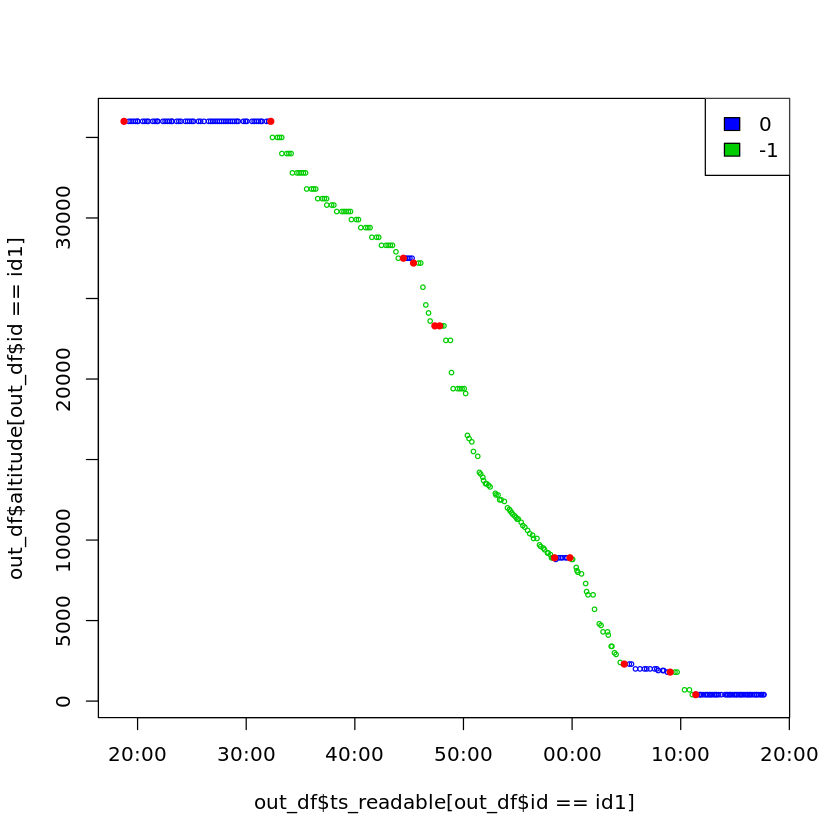

In [10]:
id1 <- "0C6015_0"
plot(out_df$ts_readable[out_df$id == id1], out_df$altitude[out_df$id == id1],
     col = out_df$climb_rate_sign[out_df$id == id1] + 4, cex = 0.5)
points(out_df$ts_readable[out_df$id == id1 & out_df$decision_point],
       out_df$altitude[out_df$id == id1 & out_df$decision_point],
       col = "red", cex = 1, pch = 20)
legend("topright", legend = unique(out_df$climb_rate_sign[out_df$id == id1]),
       fill = unique(out_df$climb_rate_sign[out_df$id == id1]) + 4)

# Conclusion

- Works reasonably well!